# ML4SCI Hackathon entry submitted by Team :

(In alphabetical order)

Jing Lu - lujingeve158@gmail.com

Lawrence Ng - lng1492@gmail.com

Pak Ki Henry Tsang - henrytsang222@gmail.com

# Exploring the Moon with Machine Learning

<a href="https://drive.google.com/uc?export=view&id=1hCl8j1aP_9D5KBu943BH7hDfNXt6U8a5"><img src="https://drive.google.com/uc?export=view&id=1hCl8j1aP_9D5KBu943BH7hDfNXt6U8a5" style="width: 650px; max-width: 100%; height: auto" title="Click to enlarge picture" />

# Chemical Composition Map


<a href="https://drive.google.com/uc?export=view&id=1OaA9PJ5IZN797-DwgaXYKlvY9dO8i0nK"><img src="https://drive.google.com/uc?export=view&id=1OaA9PJ5IZN797-DwgaXYKlvY9dO8i0nK" style="width: 650px; max-width: 100%; height: auto" title="Click to enlarge picture" />


### The chemical composition of lunar rocks determines how light or dark the surface is. Note the relationship between Element A and dark regions on the Moon in the above maps. 

### Machine learning can discover the relationship between the visible appearance of the Moon (its albedo) and its chemical composition. 

### Your task is to predict the elements A, B, C, and D using the lunar albedo map and other elements. We have withheld a region by setting all values to zero. DO NOT TRAIN OR TEST ON THIS. Your score will be measured using the combined mean-squared error of all element maps. You may use different models for each element, or you can submit a single model.

# Start Coding

### Import necessary libraries

In [219]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import pickle

import os
import glob
import time
import numpy as np
from PIL import Image
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import random

import torch
from torch import nn, optim
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

np.random.seed(123)

%matplotlib inline

### Load data

#### The data consists of the lunar albedo map and four element maps

It can be found at https://drive.google.com/drive/folders/1zwBGJdwG0Lk2MNAeWMypxebWfqt4btsx?usp=sharing

In [220]:
# Where the data is
data_path = './Data/'

# Names of the files
albedo_file    = data_path + 'Albedo.csv'
element_A_file = data_path + 'Element_A_Map.csv'
element_B_file = data_path + 'Element_B_Map.csv'
element_C_file = data_path + 'Element_C_Map.csv'
element_D_file = data_path + 'Element_D_Map.csv'


In [221]:
albedo_data = pd.read_csv(albedo_file, sep=',',header=None)
albedo_data = albedo_data.values

element_A_data = pd.read_csv(element_A_file, sep=',',header=None)
element_A_data = element_A_data.values

element_B_data = pd.read_csv(element_B_file, sep=',',header=None)
element_B_data = element_B_data.values

element_C_data = pd.read_csv(element_C_file, sep=',',header=None)
element_C_data = element_C_data.values

element_D_data = pd.read_csv(element_D_file, sep=',',header=None)
element_D_data = element_D_data.values

In [222]:
data_shape = albedo_data.shape

In [223]:
masked_rows, masked_columns = np.where(albedo_data == 0)
twoD_mask = albedo_data == 0

### Plot Data

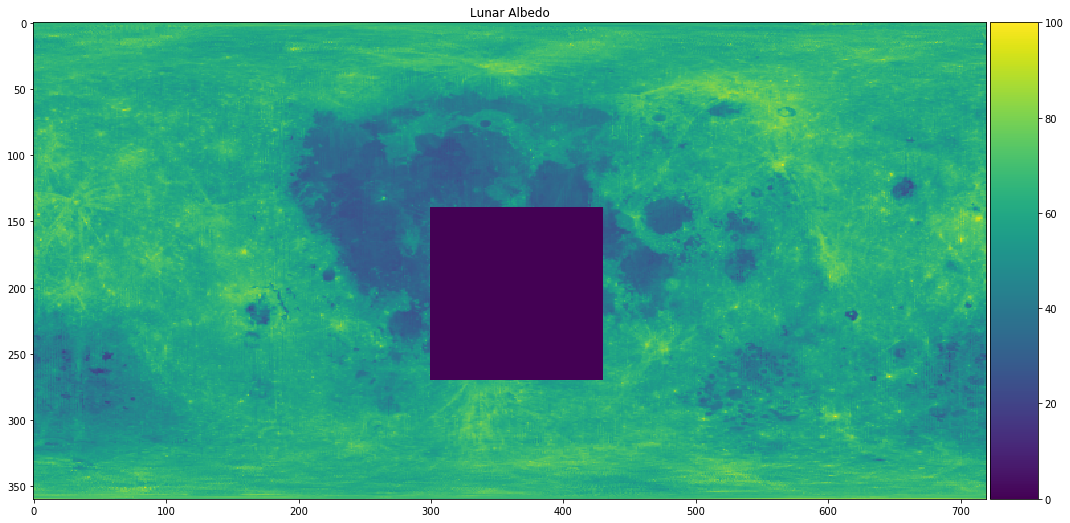

In [224]:
# Albedo
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(18, 13.5))

im = ax.imshow(albedo_data, vmax=100, vmin=0)
ax.set_title('Lunar Albedo')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

plt.show()

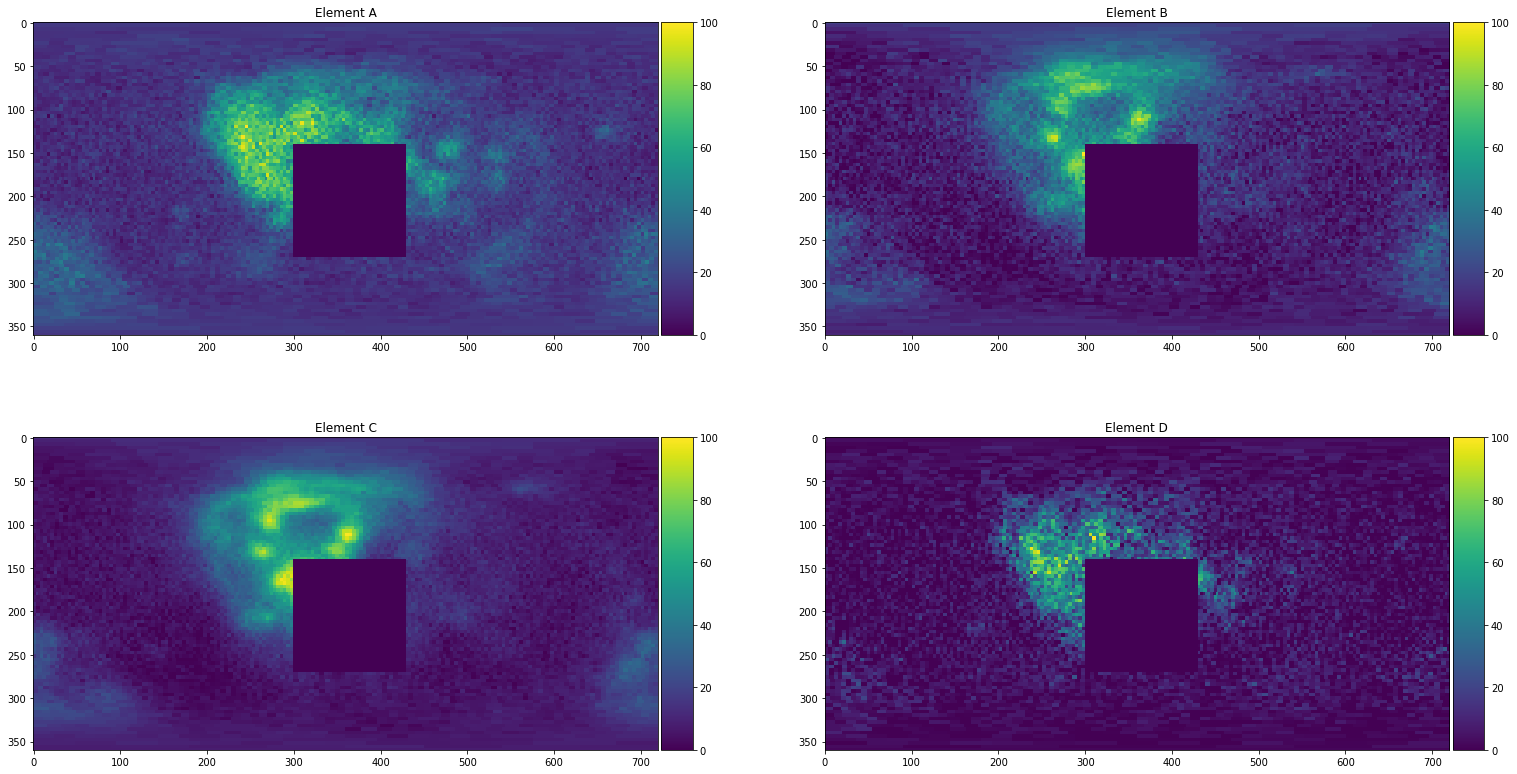

In [225]:
# Elements
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(26, 14))

im = axs[0, 0].imshow(element_A_data, vmax=100, vmin=0)
axs[0, 0].set_title('Element A')
divider = make_axes_locatable(axs[0, 0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = axs[0, 1].imshow(element_B_data, vmax=100, vmin=0)
axs[0, 1].set_title('Element B')
divider = make_axes_locatable(axs[0, 1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = axs[1, 0].imshow(element_C_data, vmax=100, vmin=0)
axs[1, 0].set_title('Element C')
divider = make_axes_locatable(axs[1, 0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = axs[1, 1].imshow(element_D_data, vmax=100, vmin=0)
axs[1, 1].set_title('Element D')
divider = make_axes_locatable(axs[1, 1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

plt.show()

In [226]:
# Flatten the data (for linear regression only)
albedo    = albedo_data.flatten()
element_A = element_A_data.flatten()
element_B = element_B_data.flatten()
element_C = element_C_data.flatten()
element_D = element_D_data.flatten()

flat_unmasked_indices = np.where(albedo > 0)
flat_masked_indices   = np.where(albedo == 0)
flat_mask = albedo == 0

### Prepare data as a tensor

we also renormalize such that data ranges from [-1,1] instead of [0,100]

In [227]:
def fromData(data):
    return (np.array(data)+1.)*50

def toData(raw):
    return (raw/50.)-1.

In [228]:
lunar_data = np.vstack((albedo,element_A,element_B,element_C,element_D)).T.reshape((360,720,5))
lunar_data = lunar_data/50-1 #renormalize to range from -1 to 1

### Prepare dataset by random cropping

Create dataset by randomly cropping the image into 64*64 dataset
The withheld region is a square : row 140:270 , col 300:430

In [229]:
ncrops=10000

randrows=np.random.randint(296, size=(ncrops))
randcols=np.random.randint(656, size=(ncrops))
randpts=np.vstack((randrows,randcols)).T

randpts_exclude = []
for pts in randpts:
    if not((pts[0]<270 and pts[0]>=140-64) and (pts[1]<430 and pts[1]>=300-64)):
        randpts_exclude.append(pts)
randpts_exclude=np.array(randpts_exclude)

In [230]:
lunar_data_crops = []

for pts in randpts_exclude:
    n=random.randint(0, 3)
    if (n==0): #Randomly decide if we flip horizontally or not
        lunar_data_crops.append(lunar_data[pts[0]:pts[0]+64,pts[1]:pts[1]+64])
    elif (n==1):
        lunar_data_crops.append((lunar_data[pts[0]:pts[0]+64,pts[1]:pts[1]+64])[:,::-1]) #flip horizontally
    elif (n==2):
        lunar_data_crops.append((lunar_data[pts[0]:pts[0]+64,pts[1]:pts[1]+64])[::-1,:]) #flip vertically
    else:
        lunar_data_crops.append((lunar_data[pts[0]:pts[0]+64,pts[1]:pts[1]+64])[::-1,::-1]) #flip both

lunar_data_crops=np.array(lunar_data_crops)

### Show the upper left corner of the cropping

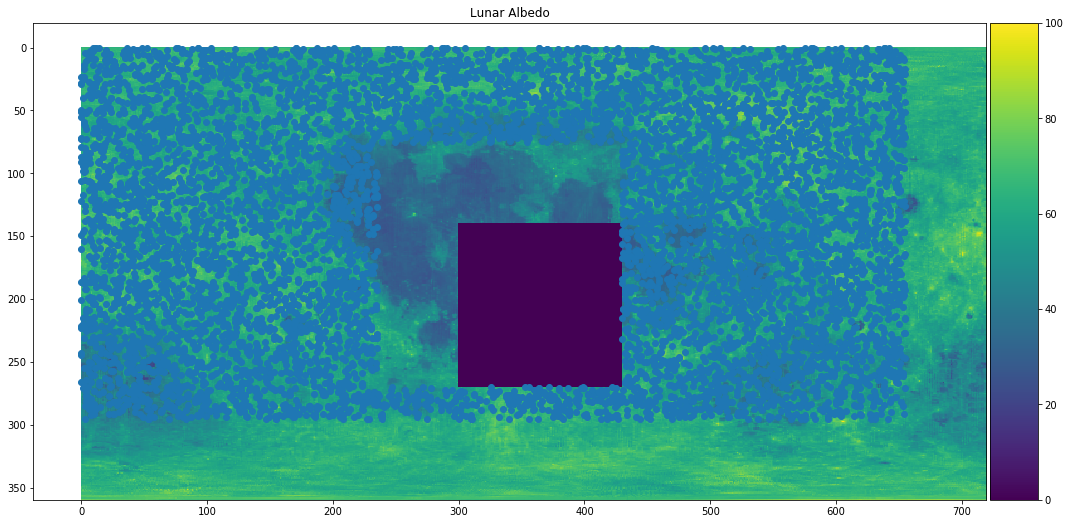

In [231]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(18, 13.5))

im = ax.imshow(albedo_data, vmax=100, vmin=0)
ax.scatter(randpts_exclude[:,1],randpts_exclude[:,0])
ax.set_title('Lunar Albedo')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
plt.show()

### Plot first 25 cropped albedo in dataset

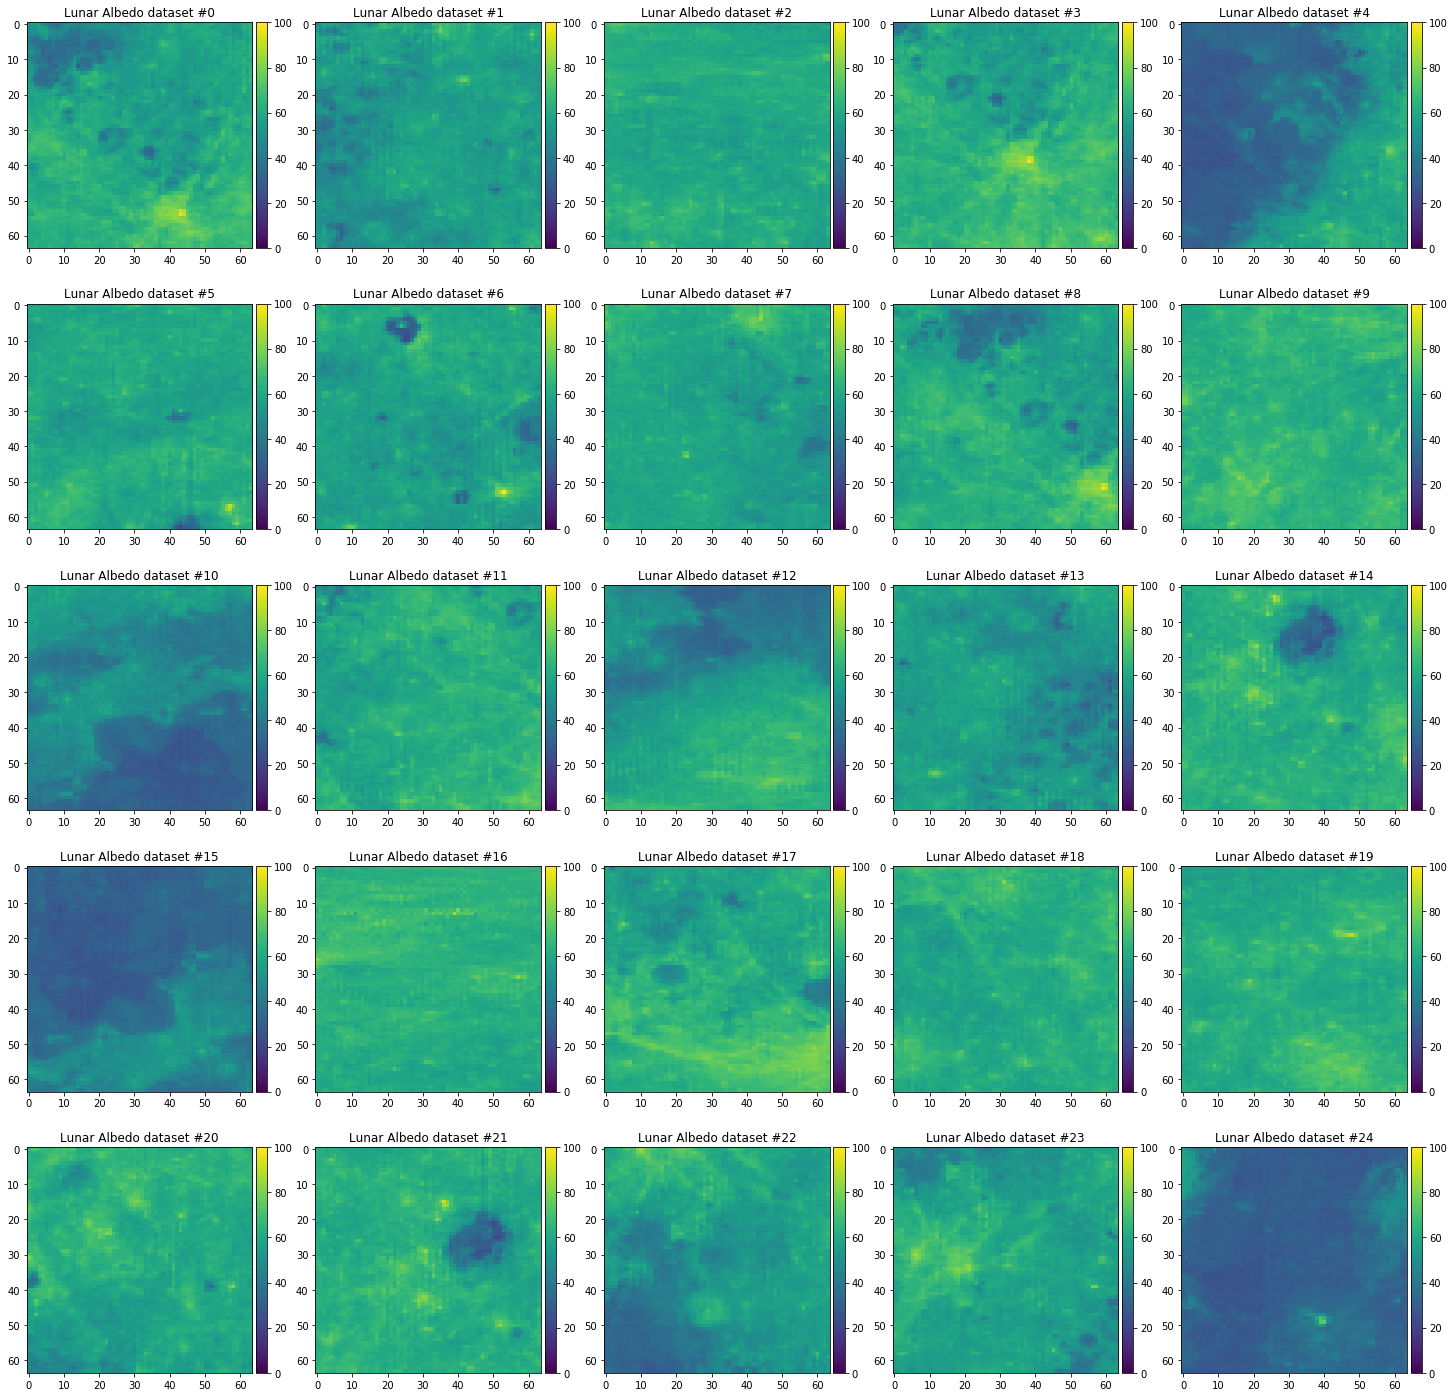

In [232]:
fig, ax = plt.subplots(ncols=5, nrows=5, figsize=(25, 25))

for i in range(25):

    im = ax[int(i/5),int(i%5)].imshow(fromData(lunar_data_crops[i][:,:,0]), vmax=100, vmin=0)
    ax[int(i/5),int(i%5)].set_title('Lunar Albedo dataset #%d'%i)
    divider = make_axes_locatable(ax[int(i/5),int(i%5)])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')

plt.show()

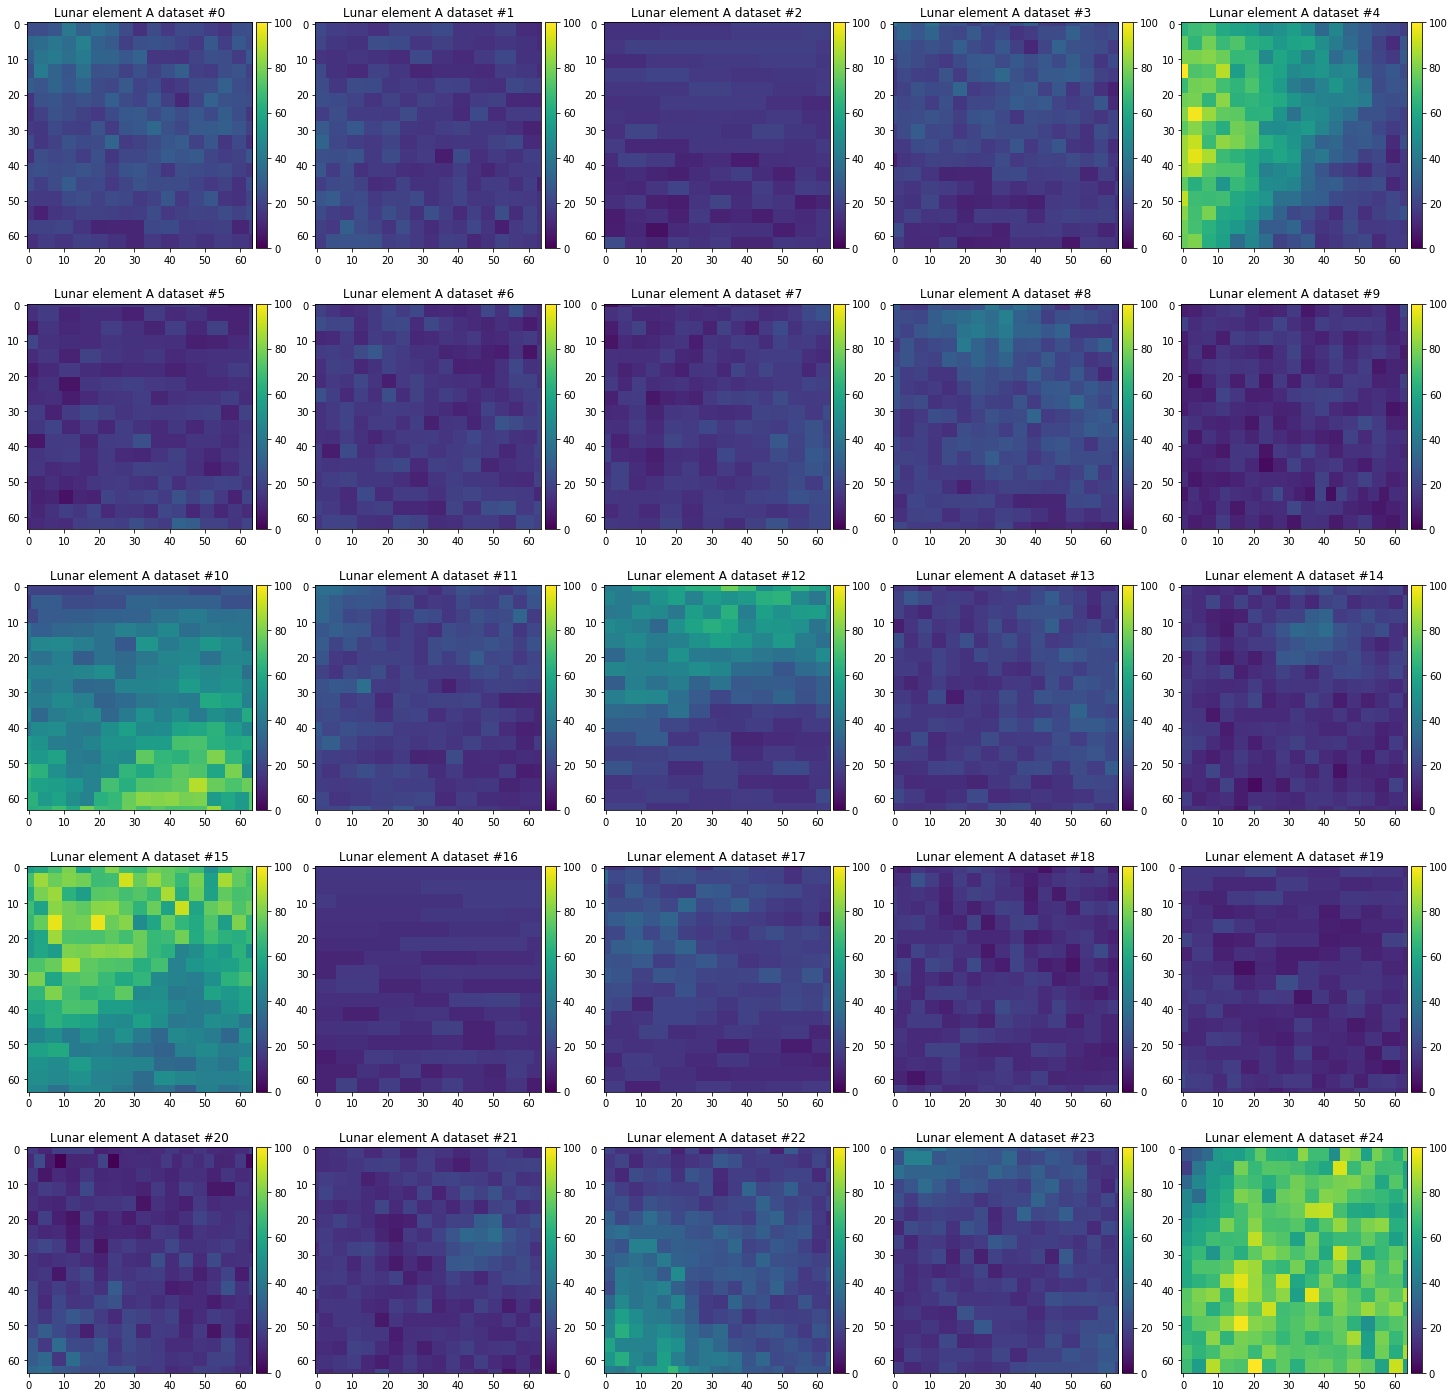

In [233]:
fig, ax = plt.subplots(ncols=5, nrows=5, figsize=(25, 25))

for i in range(25):

    im = ax[int(i/5),int(i%5)].imshow(fromData(lunar_data_crops[i][:,:,1]), vmax=100, vmin=0)
    ax[int(i/5),int(i%5)].set_title('Lunar element A dataset #%d'%i)
    divider = make_axes_locatable(ax[int(i/5),int(i%5)])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')

plt.show()

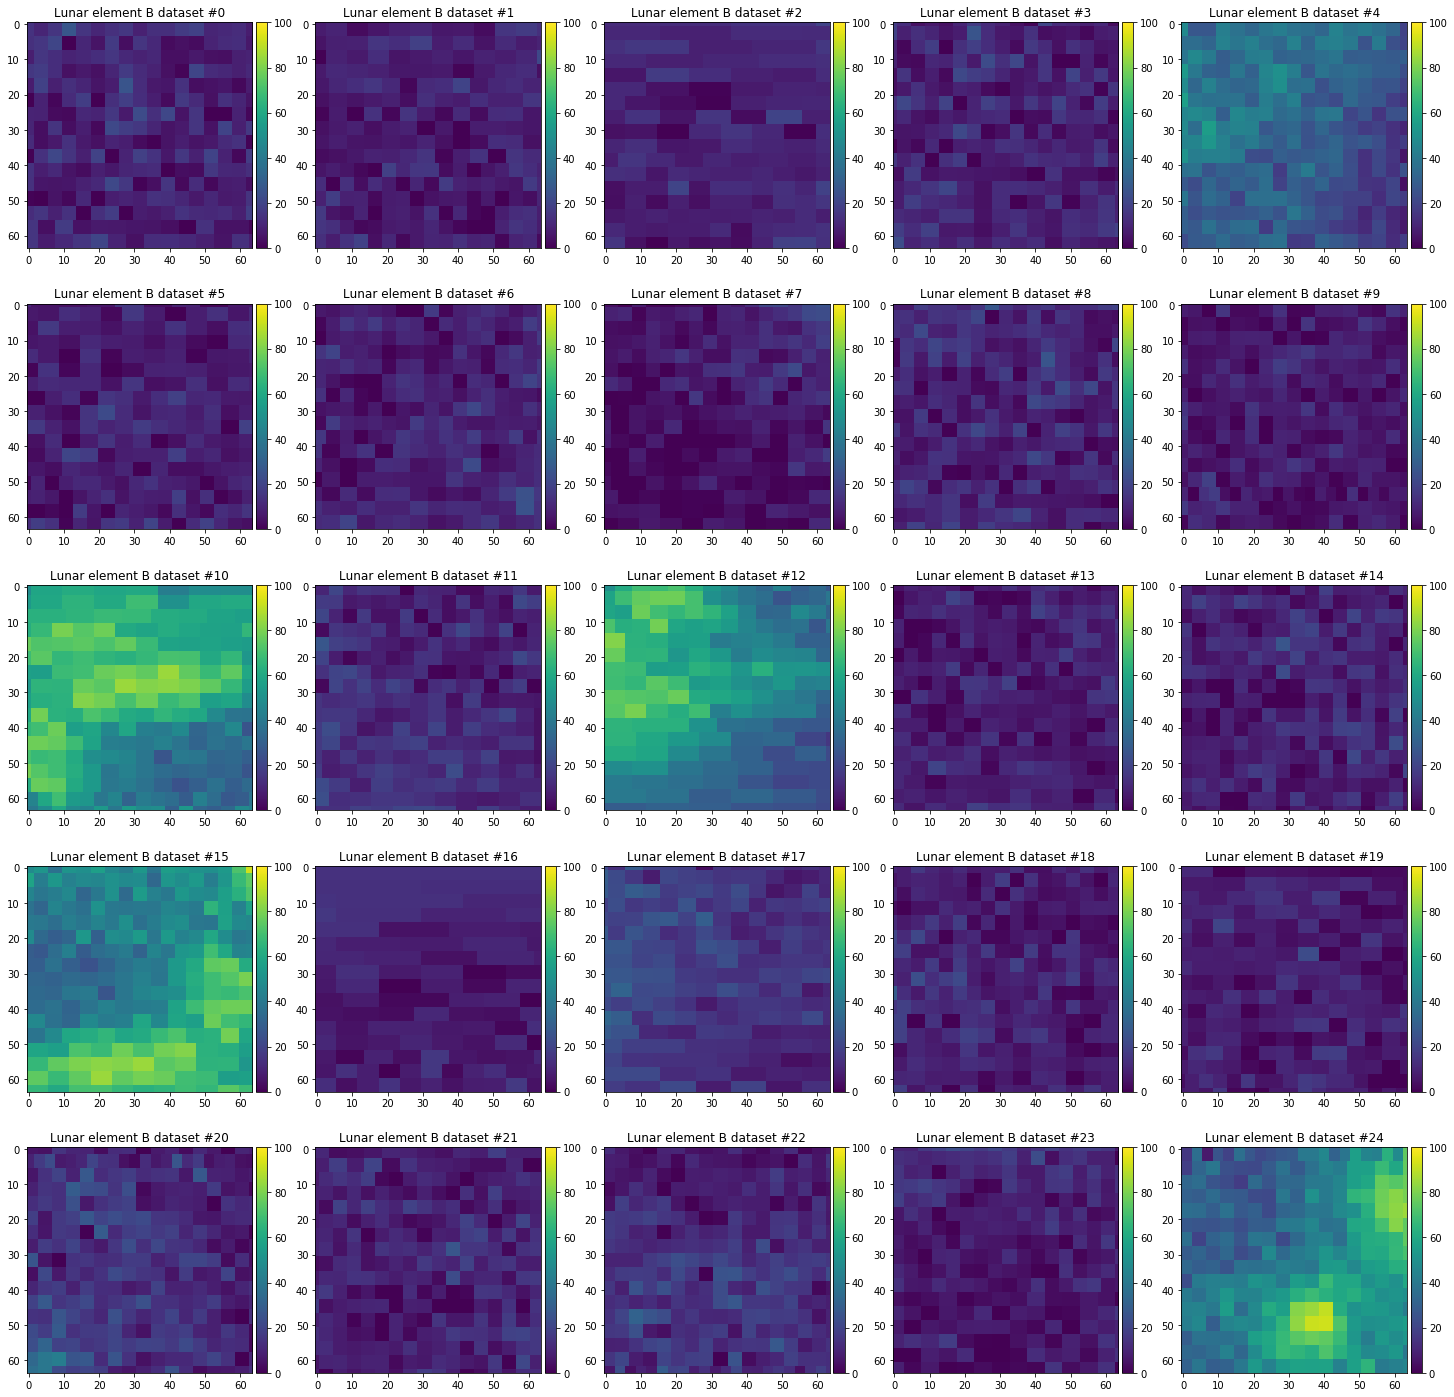

In [234]:
fig, ax = plt.subplots(ncols=5, nrows=5, figsize=(25, 25))

for i in range(25):

    im = ax[int(i/5),int(i%5)].imshow(fromData(lunar_data_crops[i][:,:,2]), vmax=100, vmin=0)
    ax[int(i/5),int(i%5)].set_title('Lunar element B dataset #%d'%i)
    divider = make_axes_locatable(ax[int(i/5),int(i%5)])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')

plt.show()

### Data loader

Dataset will be stored in "lunar_data_crops", we need to help pytorch access them

In [235]:
SIZE = 256
class LunarDataset(Dataset):
    def __init__(self,idxs, split='train'):
        self.transforms = transforms.Resize((SIZE, SIZE),  Image.BICUBIC)
        self.split = split
        self.size = SIZE
        self.lunar_data_crops = lunar_data_crops[idxs]
    
    def __getitem__(self, idx):
        img = transforms.ToTensor()(self.lunar_data_crops[idx].astype("float32"))

        albedo_tensor = img[[0], ...]
        ABCD_tensor = img[[1,2,3,4],...]
        
        return {'albedo': albedo_tensor, 'abcd': ABCD_tensor}
    
    def __len__(self):
        return len(self.lunar_data_crops)

def make_dataloaders(batch_size=16, n_workers=4, pin_memory=True, **kwargs):
    dataset = LunarDataset(**kwargs)
    dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=n_workers,pin_memory=pin_memory)
    return dataloader

### Split data into training and testing sets

We split our collection of crops into training and validation

In [236]:
rand_idxs = np.random.permutation(len(randpts_exclude))
training_cut = int(len(randpts_exclude)*0.8)
print(training_cut)
train_idxs = rand_idxs[:training_cut] # choosing the first 8000 as training set
val_idxs = rand_idxs[training_cut:] # choosing last 2000 as validation set

6452


### load the data

note that albedos is 16 images, while abcd is 16*4 images

In [237]:
train_dl = make_dataloaders(idxs=train_idxs,split='train')
val_dl = make_dataloaders(idxs=val_idxs,split='val')

data = next(iter(train_dl))
albedos, abcds_ = data['albedo'], data['abcd']
print(albedos.shape, abcds_.shape)
print(len(train_dl), len(val_dl))

torch.Size([16, 1, 64, 64]) torch.Size([16, 4, 64, 64])
404 101


# image prediction using U-net and GAN

This technique is used in image coloring, which is a mathematically identical problem. So we apply the exact same technique to this problem.

In [238]:
class UnetBlock(nn.Module):
    def __init__(self, nf, ni, submodule=None, input_c=None, dropout=False,
                 innermost=False, outermost=False):
        super().__init__()
        self.outermost = outermost
        if input_c is None: input_c = nf
        downconv = nn.Conv2d(input_c, ni, kernel_size=4,
                             stride=2, padding=1, bias=False)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = nn.BatchNorm2d(ni)
        uprelu = nn.ReLU(True)
        upnorm = nn.BatchNorm2d(nf)
        
        if outermost:
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4,
                                        stride=2, padding=1)
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost:
            upconv = nn.ConvTranspose2d(ni, nf, kernel_size=4,
                                        stride=2, padding=1, bias=False)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4,
                                        stride=2, padding=1, bias=False)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]
            if dropout: up += [nn.Dropout(0.5)]
            model = down + [submodule] + up
        self.model = nn.Sequential(*model)
    
    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:
            return torch.cat([x, self.model(x)], 1)

class Unet(nn.Module):
    def __init__(self, input_c=1, output_c=2, n_down=8, num_filters=64):
        super().__init__()
        unet_block = UnetBlock(num_filters * 8, num_filters * 8, innermost=True)
        for _ in range(n_down - 5):
            unet_block = UnetBlock(num_filters * 8, num_filters * 8, submodule=unet_block, dropout=True)
        out_filters = num_filters * 8
        for _ in range(3):
            unet_block = UnetBlock(out_filters // 2, out_filters, submodule=unet_block)
            out_filters //= 2
        self.model = UnetBlock(output_c, out_filters, input_c=input_c, submodule=unet_block, outermost=True)
    
    def forward(self, x):
        return self.model(x)

In [239]:
class PatchDiscriminator(nn.Module):
    def __init__(self, input_c, num_filters=64, n_down=5):
        super().__init__()
        model = [self.get_layers(input_c, num_filters, norm=False)]
        model += [self.get_layers(num_filters * 2 ** i, num_filters * 2 ** (i + 1), s=1 if i == (n_down-1) else 2) 
                          for i in range(n_down)] # the 'if' statement is taking care of not using
                                                  # stride of 2 for the last block in this loop
        model += [self.get_layers(num_filters * 2 ** n_down, 1, s=1, norm=False, act=False)] # Make sure to not use normalization or
                                                                                             # activation for the last layer of the model
        self.model = nn.Sequential(*model)                                                   
        
    def get_layers(self, ni, nf, k=4, s=2, p=1, norm=True, act=True): # when needing to make some repeatitive blocks of layers,
        layers = [nn.Conv2d(ni, nf, k, s, p, bias=not norm)]          # it's always helpful to make a separate method for that purpose
        if norm: layers += [nn.BatchNorm2d(nf)]
        if act: layers += [nn.LeakyReLU(0.2, True)]
        return nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [240]:
discriminator = PatchDiscriminator(5)
dummy_input = torch.randn(16, 5, 256, 256) # batch_size, channels, size, size
out = discriminator(dummy_input)
out.shape

torch.Size([16, 1, 6, 6])

In [241]:
class GANLoss(nn.Module):
    def __init__(self, gan_mode='vanilla', real_label=1.0, fake_label=0.0):
        super().__init__()
        self.register_buffer('real_label', torch.tensor(real_label))
        self.register_buffer('fake_label', torch.tensor(fake_label))
        if gan_mode == 'vanilla':
            self.loss = nn.BCEWithLogitsLoss()
        elif gan_mode == 'lsgan':
            self.loss = nn.MSELoss()
    
    def get_labels(self, preds, target_is_real):
        if target_is_real:
            labels = self.real_label
        else:
            labels = self.fake_label
        return labels.expand_as(preds)
    
    def __call__(self, preds, target_is_real):
        labels = self.get_labels(preds, target_is_real)
        loss = self.loss(preds, labels)
        return loss

In [242]:
def init_weights(net, init='norm', gain=0.02):
    
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and 'Conv' in classname:
            if init == 'norm':
                nn.init.normal_(m.weight.data, mean=0.0, std=gain)
            elif init == 'xavier':
                nn.init.xavier_normal_(m.weight.data, gain=gain)
            elif init == 'kaiming':
                nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            
            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias.data, 0.0)
        elif 'BatchNorm2d' in classname:
            nn.init.normal_(m.weight.data, 1., gain)
            nn.init.constant_(m.bias.data, 0.)
            
    net.apply(init_func)
    print(f"model initialized with {init} initialization")
    return net

def init_model(model, device):
    model = model.to(device)
    model = init_weights(model)
    return model

In [243]:
class MainModel(nn.Module):
    def __init__(self, net_G=None, lr_G=2e-4, lr_D=2e-4, 
                 beta1=0.5, beta2=0.999, lambda_L1=100.):
        super().__init__()
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.lambda_L1 = lambda_L1
        
        if net_G is None:
            self.net_G = init_model(Unet(input_c=1, output_c=4, n_down=6, num_filters=64), self.device)
        else:
            self.net_G = net_G.to(self.device)
        self.net_D = init_model(PatchDiscriminator(input_c=5, n_down=3, num_filters=64), self.device)
        self.GANcriterion = GANLoss(gan_mode='vanilla').to(self.device)
        self.L1criterion = nn.L1Loss()
        self.opt_G = optim.Adam(self.net_G.parameters(), lr=lr_G, betas=(beta1, beta2))
        self.opt_D = optim.Adam(self.net_D.parameters(), lr=lr_D, betas=(beta1, beta2))
    
    def set_requires_grad(self, model, requires_grad=True):
        for p in model.parameters():
            p.requires_grad = requires_grad
        
    def setup_input(self, data):
        self.albedo = data['albedo'].to(self.device)
        self.abcd = data['abcd'].to(self.device)
        
    def forward(self):
        self.fake_color = self.net_G(self.albedo)
    
    def backward_D(self):
        fake_image = torch.cat([self.albedo, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image.detach())
        self.loss_D_fake = self.GANcriterion(fake_preds, False)
        real_image = torch.cat([self.albedo, self.abcd], dim=1)
        real_preds = self.net_D(real_image)
        self.loss_D_real = self.GANcriterion(real_preds, True)
        self.loss_D = (self.loss_D_fake + self.loss_D_real) * 0.5
        self.loss_D.backward()
    
    def backward_G(self):
        fake_image = torch.cat([self.albedo, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image)
        self.loss_G_GAN = self.GANcriterion(fake_preds, True)
        self.loss_G_L1 = self.L1criterion(self.fake_color, self.abcd) * self.lambda_L1
        self.loss_G = self.loss_G_GAN + self.loss_G_L1
        self.loss_G.backward()
    
    def optimize(self):
        self.forward()
        self.net_D.train()
        self.set_requires_grad(self.net_D, True)
        self.opt_D.zero_grad()
        self.backward_D()
        self.opt_D.step()
        
        self.net_G.train()
        self.set_requires_grad(self.net_D, False)
        self.opt_G.zero_grad()
        self.backward_G()
        self.opt_G.step()

In [244]:
class AverageMeter:
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.count, self.avg, self.sum = [0.] * 3
    
    def update(self, val, count=1):
        self.count += count
        self.sum += count * val
        self.avg = self.sum / self.count

def create_loss_meters():
    loss_D_fake = AverageMeter()
    loss_D_real = AverageMeter()
    loss_D = AverageMeter()
    loss_G_GAN = AverageMeter()
    loss_G_L1 = AverageMeter()
    loss_G = AverageMeter()
    
    return {'loss_D_fake': loss_D_fake,
            'loss_D_real': loss_D_real,
            'loss_D': loss_D,
            'loss_G_GAN': loss_G_GAN,
            'loss_G_L1': loss_G_L1,
            'loss_G': loss_G}

def update_losses(model, loss_meter_dict, count):
    for loss_name, loss_meter in loss_meter_dict.items():
        loss = getattr(model, loss_name)
        loss_meter.update(loss.item(), count=count)

def visualize(model, data, save=True):
    model.net_G.eval()
    with torch.no_grad():
        model.setup_input(data)
        model.forward()
    model.net_G.train()
    prediction = model.fake_color.detach()
    reality = model.abcd
    albedo = model.albedo
    
    fig = plt.figure(figsize=(15, 8))
    for i in range(5):
        ax = plt.subplot(3, 5, i + 1)
        ax.imshow(fromData(albedo[i][0].cpu()))
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 5)
        ax.imshow(fromData(prediction[i][0].cpu()))
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 10)
        ax.imshow(fromData(reality[i][0].cpu()))
        ax.axis("off")
    plt.show()
    if save:
        fig.savefig(f"albedotrain_{time.time()}.png")
        
def log_results(loss_meter_dict):
    for loss_name, loss_meter in loss_meter_dict.items():
        print(f"{loss_name}: {loss_meter.avg:.5f}")

# Training

In [245]:
def train_model(model, train_dl, epochs, display_every=200):
    vdata = next(iter(val_dl)) # getting a batch for visualizing the model output after fixed intervals
    for e in range(epochs):
        loss_meter_dict = create_loss_meters() # function returing a dictionary of objects to 
        i = 0                                  # log the losses of the complete network
        for data in tqdm(train_dl):
            model.setup_input(data) 
            model.optimize()
            update_losses(model, loss_meter_dict, count=data['albedo'].size(0)) # function updating the log objects
            i += 1
            if i % display_every == 0:
                print(f"\nEpoch {e+1}/{epochs}")
                print(f"Iteration {i}/{len(train_dl)}")
                log_results(loss_meter_dict) # function to print out the losses
                visualize(model, vdata, save=False) # function displaying the model's outputs

In [246]:
model = MainModel()

model initialized with norm initialization
model initialized with norm initialization


In [ ]:
train_model(model, train_dl, 100)

### Save the model

In [248]:
torch.save(model.state_dict(), './model.sav')

## Making predictions

### Load trained model

In [249]:
model = MainModel()
model.load_state_dict(torch.load('./model.sav'))
model.eval()
print("loading model")

model initialized with norm initialization
model initialized with norm initialization
loading model


### SLOW method of utilizing the model prediction

We scan the input image from left to right, top to bottom with certain strides. Then we stitch together the predictions using averages.

This process uses up quite a lot of memory (tested on 11GB of video mem)

In [250]:
SIZE = 256
class PredictionDataset(Dataset):
    def __init__(self,data, split='train'):
        self.transforms = transforms.Resize((SIZE, SIZE),  Image.BICUBIC)
        self.split = split
        self.size = SIZE
        self.lunar_data_crops = data

    def __getitem__(self, idx):
        img = transforms.ToTensor()(self.lunar_data_crops[idx].astype("float32"))

        albedo_tensor = img[[0], ...]
        ABCD_tensor = img[[1,2,3,4],...]

        return {'albedo': albedo_tensor, 'abcd': ABCD_tensor}

    def __len__(self):
        return len(self.lunar_data_crops)

def make_prediction_dataloaders(batch_size=16, n_workers=4, pin_memory=True, **kwargs):
    dataset = PredictionDataset(**kwargs)
    dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=n_workers,pin_memory=pin_memory)
    return dataloader


def stitchRow(crop,xlen,ylen,xpad,ypad,xstride=2,ystride=2,size=64):

    rowdata=crop[0][:,:]
    #Merge a row by averaging
    for i in range(1,xlen):
        rowdata = np.hstack((rowdata[:,:-size+xstride],(rowdata[:,-size+xstride:]+crop[i][:,:-xstride])/2.,crop[i][:,-xstride:]))

    if (xpad!=0):
        rowdata = np.hstack((rowdata[:,:-size+xstride-xpad],(rowdata[:,-size+xstride-xpad:]+crop[xlen][:,:-xstride+xpad])/2.,crop[xlen][:,-xstride+xpad:]))


    
    return rowdata

def stitchY(img1,img2,xstride=2,ystride=2,size=64):
    
    return np.vstack((img1[:-size+ystride,:],(img1[-size+ystride:,:]+img2[:-ystride,:])/2.,img2[-ystride:,:]))

def predictS(albedo_data):

    prediction_A=None
    prediction_B=None
    prediction_C=None
    prediction_D=None
    size=64 #only size 64 was tested
    xstride=2 #So far only stride=2 works, somehow things were buggy
    ystride=2 #So far only stride=2 works, somehow things were buggy


    xsize = len(albedo_data[0])
    ysize = len(albedo_data)
    xlen=int((xsize-size)/xstride)+1
    ylen=int((ysize-size)/ystride)+1
    ypad=ysize%ystride
    xpad=xsize%xstride


    for j in range(ylen): #row idx

        data = albedo_data[j*ystride:j*ystride+size]

        slicedData=[]
        y=j*ystride
        for i in range(xlen):
            x=i*xstride
            slicedData.append(data[:,x:x+size])
        if (xpad!=0):
            slicedData.append(data[:,xlen*xstride-xpad:xlen*xstride+size-xpad])
        slicedData=np.array(slicedData)

        zeros=np.zeros((len(slicedData),size,size,4))
        predictiondata=np.concatenate((slicedData[:,:,:,np.newaxis],zeros),axis=3)/50.-1.
        pred_dl = make_prediction_dataloaders(batch_size=len(slicedData),data=predictiondata)


        preddata = next(iter(pred_dl))
        predalbedos = preddata ['albedo']
        #print(predalbedos.shape)
        model.net_G.eval()
        with torch.no_grad():
            model.setup_input(preddata)
            model.forward()
        model.net_G.train()
        prediction = model.fake_color.detach()
        albedoP = model.albedo

        prediction_data_A=[]
        prediction_data_B=[]
        prediction_data_C=[]
        prediction_data_D=[]
        for i in range(len(slicedData)):
            prediction_data_A.append(fromData(prediction[i][0].cpu()))
            prediction_data_B.append(fromData(prediction[i][1].cpu()))
            prediction_data_C.append(fromData(prediction[i][2].cpu()))
            prediction_data_D.append(fromData(prediction[i][3].cpu()))

        prediction_data_A=np.array(prediction_data_A)
        prediction_data_B=np.array(prediction_data_B)
        prediction_data_C=np.array(prediction_data_C)
        prediction_data_D=np.array(prediction_data_D)

        stitched_A=stitchRow(prediction_data_A,xlen,ylen,xpad,ypad,xstride=xstride,ystride=ystride,size=size)
        stitched_B=stitchRow(prediction_data_B,xlen,ylen,xpad,ypad,xstride=xstride,ystride=ystride,size=size)
        stitched_C=stitchRow(prediction_data_C,xlen,ylen,xpad,ypad,xstride=xstride,ystride=ystride,size=size)
        stitched_D=stitchRow(prediction_data_D,xlen,ylen,xpad,ypad,xstride=xstride,ystride=ystride,size=size)

        if (j==0):
            prediction_A=stitched_A
            prediction_B=stitched_B
            prediction_C=stitched_C
            prediction_D=stitched_D
        else:
            prediction_A=stitchY(prediction_A,stitched_A)
            prediction_B=stitchY(prediction_B,stitched_B)
            prediction_C=stitchY(prediction_C,stitched_C)
            prediction_D=stitchY(prediction_D,stitched_D)

    if (ypad!=0):
        data = albedo_data[j*ystride-ypad:j*ystride-ypad+size]
        slicedData=[]
        y=j*ystride
        for i in range(xlen):
            x=i*xstride
            slicedData.append(data[:,x:x+size])
        if (xpad!=0):
            slicedData.append(data[:,xlen*xstride-xpad:xlen*xstride+size-xpad])
        slicedData=np.array(slicedData)

        zeros=np.zeros((len(slicedData),size,size,4))
        predictiondata=np.concatenate((slicedData[:,:,:,np.newaxis],zeros),axis=3)/50.-1.
        pred_dl = make_prediction_dataloaders(batch_size=len(slicedData),data=predictiondata)


        preddata = next(iter(pred_dl))
        predalbedos = preddata ['albedo']
        #print(predalbedos.shape)
        model.net_G.eval()
        with torch.no_grad():
            model.setup_input(preddata)
            model.forward()
        model.net_G.train()
        prediction = model.fake_color.detach()
        albedoP = model.albedo

        prediction_data_A=[]
        prediction_data_B=[]
        prediction_data_C=[]
        prediction_data_D=[]
        for i in range(len(slicedData)):
            prediction_data_A.append(fromData(prediction[i][0].cpu()))
            prediction_data_B.append(fromData(prediction[i][1].cpu()))
            prediction_data_C.append(fromData(prediction[i][2].cpu()))
            prediction_data_D.append(fromData(prediction[i][3].cpu()))

        prediction_data_A=np.array(prediction_data_A)
        prediction_data_B=np.array(prediction_data_B)
        prediction_data_C=np.array(prediction_data_C)
        prediction_data_D=np.array(prediction_data_D)

        stitched_A=stitchRow(prediction_data_A,xlen,ylen,xpad,ypad,xstride=xstride,ystride=ystride-ypad,size=size)
        stitched_B=stitchRow(prediction_data_B,xlen,ylen,xpad,ypad,xstride=xstride,ystride=ystride-ypad,size=size)
        stitched_C=stitchRow(prediction_data_C,xlen,ylen,xpad,ypad,xstride=xstride,ystride=ystride-ypad,size=size)
        stitched_D=stitchRow(prediction_data_D,xlen,ylen,xpad,ypad,xstride=xstride,ystride=ystride-ypad,size=size)

        prediction_A=stitchY(prediction_A,stitched_A)
        prediction_B=stitchY(prediction_B,stitched_B)
        prediction_C=stitchY(prediction_C,stitched_C)
        prediction_D=stitchY(prediction_D,stitched_D)
        
    return prediction_A,prediction_B,prediction_C,prediction_D
    

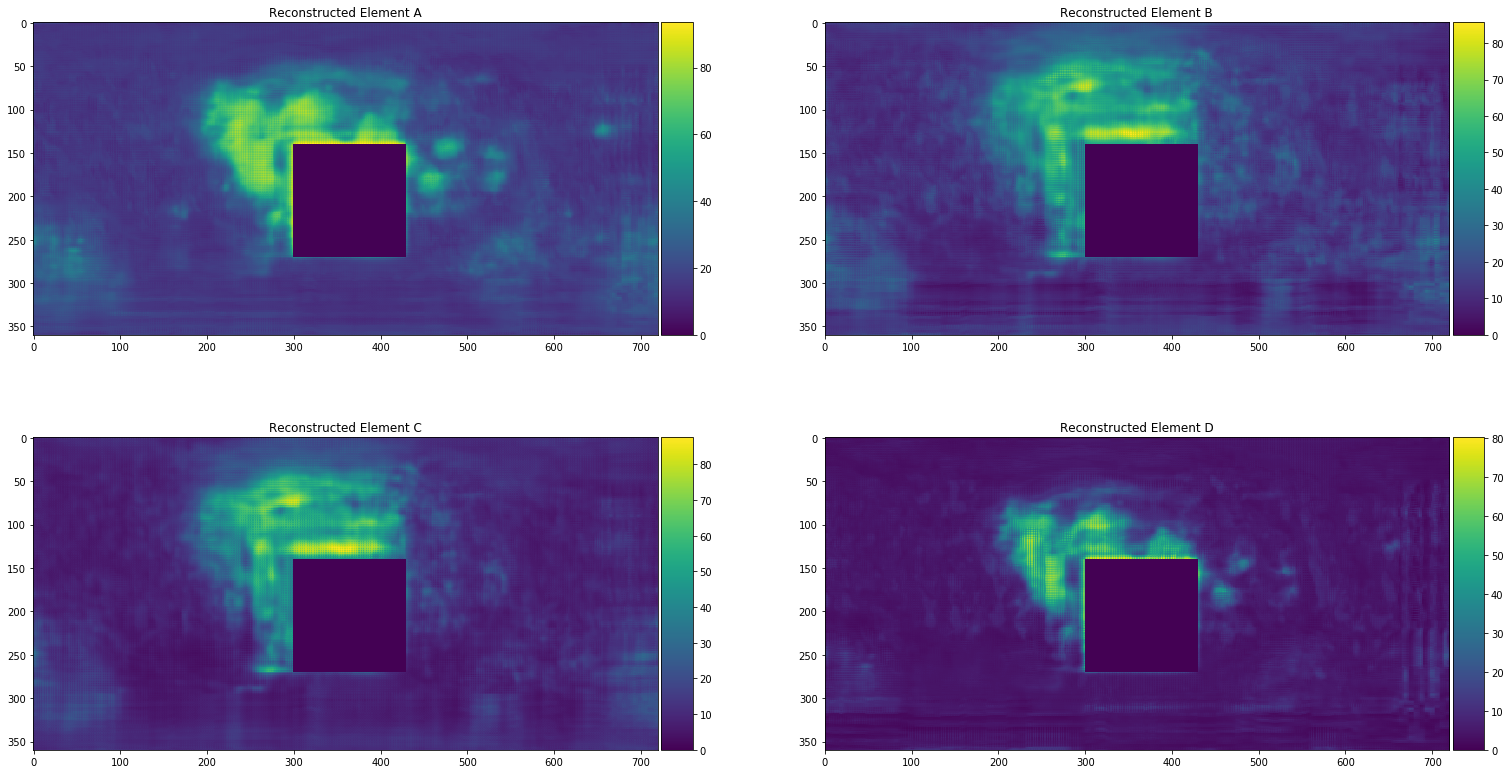

In [251]:
prediction_A,prediction_B,prediction_C,prediction_D=predictS(albedo_data)

prediction_A[140:270,300:430]=0
prediction_B[140:270,300:430]=0
prediction_C[140:270,300:430]=0
prediction_D[140:270,300:430]=0

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(26, 14))

im = axs[0, 0].imshow(prediction_A)
axs[0, 0].set_title('Reconstructed Element A')
# Set Colorbars
divider = make_axes_locatable(axs[0, 0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = axs[0, 1].imshow(prediction_B)
axs[0, 1].set_title('Reconstructed Element B')
divider = make_axes_locatable(axs[0, 1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = axs[1, 0].imshow(prediction_C)
axs[1, 0].set_title('Reconstructed Element C')
divider = make_axes_locatable(axs[1, 0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = axs[1, 1].imshow(prediction_D)
axs[1, 1].set_title('Reconstructed Element D')
divider = make_axes_locatable(axs[1, 1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

plt.show()

In [252]:
print(np.mean((prediction_A-element_A_data)**2))
print(np.mean((prediction_B-element_B_data)**2))
print(np.mean((prediction_C-element_C_data)**2))
print(np.mean((prediction_D-element_D_data)**2))


29.03395521348543
63.2987498082277
42.42914289349905
43.911708859052965


## Faster way of prediction (no stitching)

This is obviously much faster and uses less memory, but results are not as good as above

### A lesser way of cropping and stitching

In [150]:
def chopData(data,size=64):
    xsize = len(data[0])
    ysize = len(data)
    xlen=int(xsize/size)
    ylen=int(ysize/size)

    ypad=size-ysize%size
    #print(ypad)
    xpad=size-xsize%size
    #print(xpad)


    slicedData=[]
    for j in range(ylen):
        for i in range(xlen):
            slicedData.append(data[64*j:64*(j+1),64*i:64*(i+1)])
        if (xpad!=0):
            slicedData.append(data[64*j:64*(j+1),64*(xlen)-xpad:64*(xlen+1)-xpad])
    if (ypad!=0):
        for i in range(xlen):
            slicedData.append(data[64*ylen-ypad:64*(ylen+1)-ypad,64*i:64*(i+1)])
        if (xpad!=0):
            slicedData.append(data[64*ylen-ypad:64*(ylen+1)-ypad,64*(xlen)-xpad:64*(xlen+1)-xpad])

    return xlen,ylen,xpad,ypad,np.array(slicedData)

def mergeData(data,xlen,ylen,xpad,ypad,size=64):

    idx=0
    output=np.hstack((data[0:xlen]))
    idx+=xlen
    if (xpad!=0):
        output=np.hstack((output,data[idx][:,xpad:]))
        idx+=1


    for i in range(1,ylen):
        row =  np.hstack((data[idx:idx+xlen]))
        idx+=xlen
        if (xpad!=0):
            row=np.hstack((row,data[idx][:,xpad:]))
            idx+=1
        output=np.vstack((output,row))
    #print(data.shape)  
    #print(idx)
    if (ypad!=0):
        row=np.hstack((data[idx:idx+xlen][:,ypad:,:]))
        if (xpad!=0):
            row=np.hstack((row,data[-1][ypad:,xpad:]))
        output=np.vstack((output,row))
    return output

def predict(model,albedo_data):
    
    
    
    SIZE = 256
    class PredictionDataset(Dataset):
        def __init__(self,data, split='train'):
            self.transforms = transforms.Resize((SIZE, SIZE),  Image.BICUBIC)
            self.split = split
            self.size = SIZE
            self.lunar_data_crops = data

        def __getitem__(self, idx):
            img = transforms.ToTensor()(self.lunar_data_crops[idx].astype("float32"))

            albedo_tensor = img[[0], ...]
            ABCD_tensor = img[[1,2,3,4],...]

            return {'albedo': albedo_tensor, 'abcd': ABCD_tensor}

        def __len__(self):
            return len(self.lunar_data_crops)

    def make_prediction_dataloaders(batch_size=16, n_workers=4, pin_memory=True, **kwargs):
        dataset = PredictionDataset(**kwargs)
        dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=n_workers,pin_memory=pin_memory)
        return dataloader
    
    
    xlen,ylen,xpad,ypad,choppedData=chopData(albedo_data)
    zeros=np.zeros((len(choppedData),64,64,4))
    predictiondata=np.concatenate((choppedData[:,:,:,np.newaxis],zeros),axis=3)/50.-1.
    pred_dl = make_prediction_dataloaders(batch_size=len(choppedData),data=predictiondata)

    preddata = next(iter(pred_dl))
    predalbedos = preddata ['albedo']
    #print(predalbedos.shape)
    model.net_G.eval()
    with torch.no_grad():
        model.setup_input(preddata)
        model.forward()
    model.net_G.train()
    prediction = model.fake_color.detach()
    albedoP = model.albedo
    
    prediction_data_A=[]
    prediction_data_B=[]
    prediction_data_C=[]
    prediction_data_D=[]
    for i in range(len(choppedData)):
        prediction_data_A.append(fromData(prediction[i][0].cpu()))
        prediction_data_B.append(fromData(prediction[i][1].cpu()))
        prediction_data_C.append(fromData(prediction[i][2].cpu()))
        prediction_data_D.append(fromData(prediction[i][3].cpu()))

    prediction_data_A=np.array(prediction_data_A)
    prediction_data_B=np.array(prediction_data_B)
    prediction_data_C=np.array(prediction_data_C)
    prediction_data_D=np.array(prediction_data_D)
    mergedPredictionData_A=mergeData(prediction_data_A,xlen,ylen,xpad,ypad,size=64)
    mergedPredictionData_B=mergeData(prediction_data_B,xlen,ylen,xpad,ypad,size=64)
    mergedPredictionData_C=mergeData(prediction_data_C,xlen,ylen,xpad,ypad,size=64)
    mergedPredictionData_D=mergeData(prediction_data_D,xlen,ylen,xpad,ypad,size=64)
    
    return mergedPredictionData_A,mergedPredictionData_B,mergedPredictionData_C,mergedPredictionData_D


### Predict! (note that the withheld region is just being fed into the prediction)

In [151]:
element_A_pred,element_B_pred,element_C_pred,element_D_pred=predict(model,albedo_data)

element_A_pred[140:270,300:430]=0
element_B_pred[140:270,300:430]=0
element_C_pred[140:270,300:430]=0
element_D_pred[140:270,300:430]=0

In [163]:
#Compare prediction to raw data as a way of gauging how good the prediction is

print(np.mean((element_A_pred-element_A_data)**2))
print(np.mean((element_B_pred-element_B_data)**2))
print(np.mean((element_C_pred-element_C_data)**2))
print(np.mean((element_D_pred-element_D_data)**2))

48.611278073524545
131.523635654077
110.10589432773392
64.29382295986237


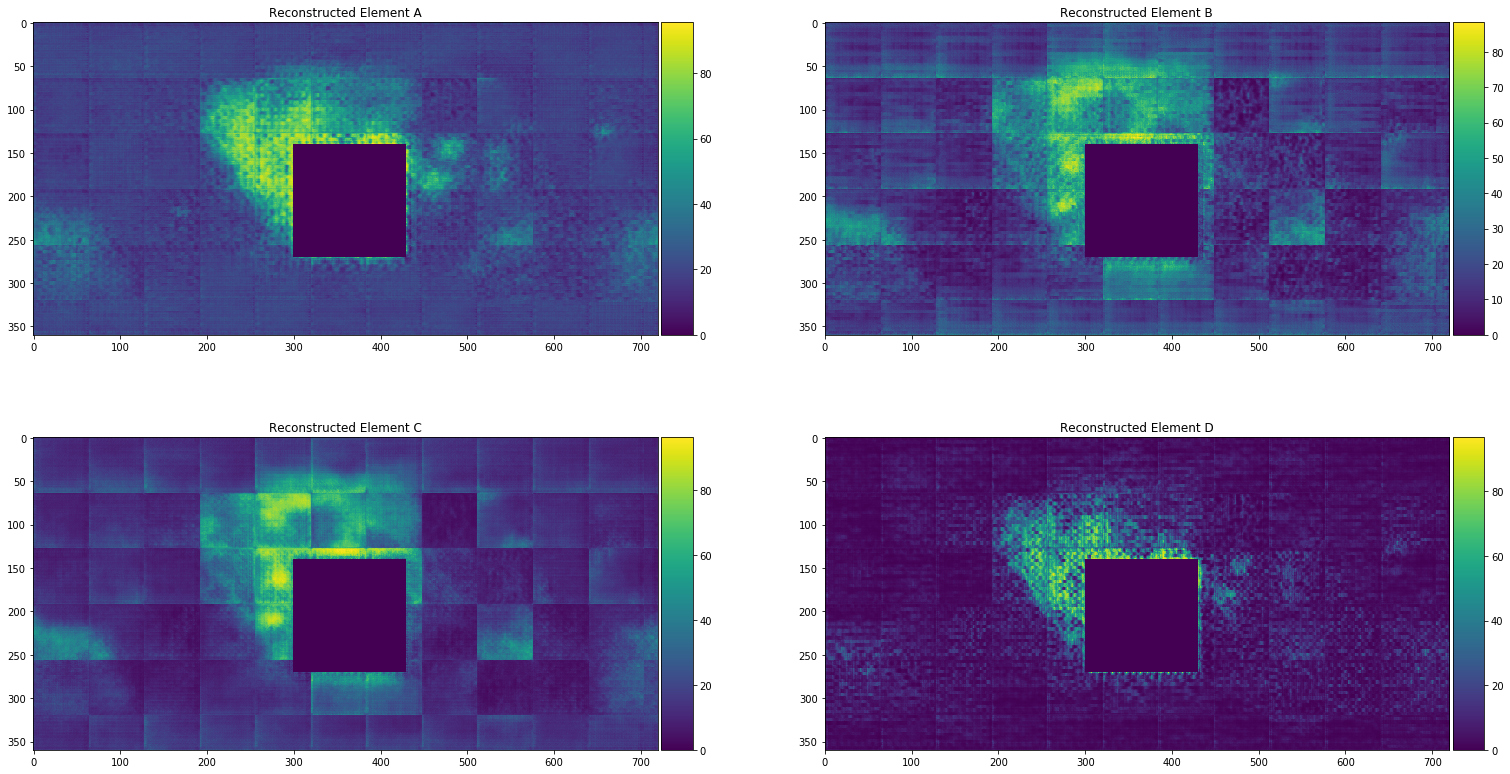

In [152]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(26, 14))

im = axs[0, 0].imshow(element_A_pred)
axs[0, 0].set_title('Reconstructed Element A')
# Set Colorbars
divider = make_axes_locatable(axs[0, 0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = axs[0, 1].imshow(element_B_pred)
axs[0, 1].set_title('Reconstructed Element B')
divider = make_axes_locatable(axs[0, 1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = axs[1, 0].imshow(element_C_pred)
axs[1, 0].set_title('Reconstructed Element C')
divider = make_axes_locatable(axs[1, 0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = axs[1, 1].imshow(element_D_pred)
axs[1, 1].set_title('Reconstructed Element D')
divider = make_axes_locatable(axs[1, 1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

plt.show()

# Deliverables

* Google Colab Jupyter Notebook showing your solution along with the final model score More details regarding the format of the notebook can be found in the sample Google Colab notebook provided for this challenge.  
* A txt file for each element containing your predictions on the test data. Format should be: x_coordinate, y_coordinate, predicted_value. Put name of element in file. An example is provided.
* The final trained model including the model architecture and the trained weights (For example: HDF5 file, .pb file, .pt, .sav file, etc.). You are free to choose Machine Learning Framework of your choice.
* Example submissions can be found https://drive.google.com/drive/folders/1EsqNLc5DzCsaJuvSTYF85gMS5PTVell4?usp=sharing

## Save models
Other formats can be used

In [891]:
torch.save(model.state_dict(), './model.sav')

loading the model

In [ ]:
model = MainModel()
model.load_state_dict(torch.load('./model.sav'))
model.eval()
print("loading model")

## Save results

NOT APPLICABLE

## Prediction with arbitrary data input

In [218]:
def resizeData(albedo_data):

    testdat=np.uint8(albedo_data*255/100)
    print("resizing from : ",testdat.shape)
    ydim,xdim=testdat.shape

    ydim_final=ydim if ydim>=64 else 64
    xdim_final=xdim if xdim>=64 else 64
    if (xdim_final!=xdim or ydim_final!=ydim):
        testimg=Image.fromarray(testdat)
        testimg=np.array(testimg.resize((xdim_final, ydim_final),  Image.NEAREST))*100./255.
        print("resized as : ",testimg.shape)
    else:
        testimg = albedo_data
    return xdim,ydim,testimg

def restoreData(prediction_data,xdim,ydim):

    testdat=np.uint8(prediction_data*255/100)
    print("resizing from : ",testdat.shape)
    ydim_ori,xdim_ori=testdat.shape

    testimg=Image.fromarray(testdat)
    testimg=np.array(testimg.resize((xdim, ydim),  Image.NEAREST))*100./255.
    print("resized as : ",testimg.shape)
    return testimg

resizing from :  (360, 720)
resized as :  (360, 720)


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f94e05c0278>>
Traceback (most recent call last):
  File "/home/henry/.local/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/henry/.local/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1295, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


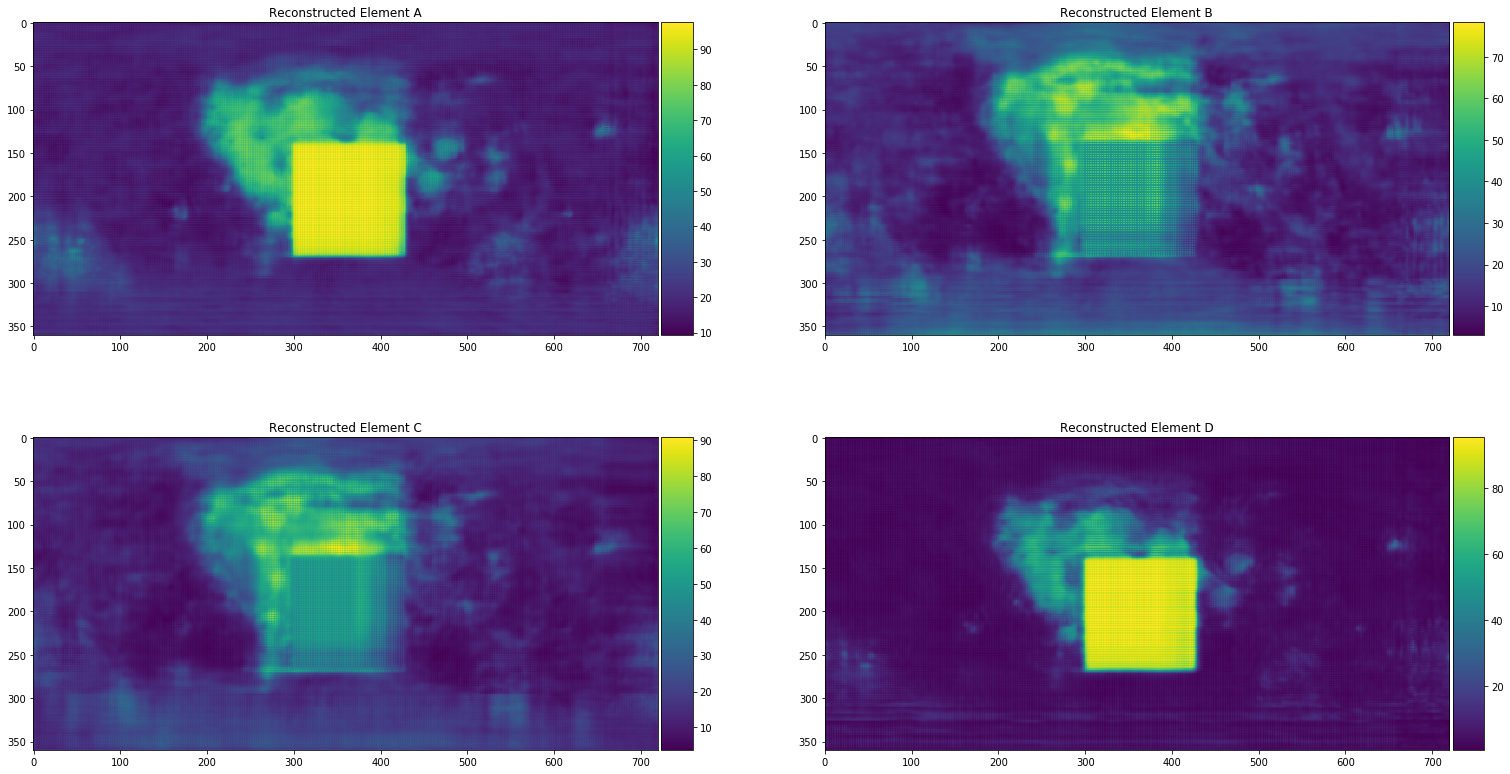

In [217]:
xdim,ydim,inputData=resizeData(albedo_data) #DATA is the array to input, we have to resize dimensions to at least 64x64 for the prediction to work

prediction_A,prediction_B,prediction_C,prediction_D=predictS(inputData)

if (prediction_A.shape!=(ydim,xdim)):
    prediction_A=restoreData(prediction_A,xdim,ydim)
    prediction_B=restoreData(prediction_B,xdim,ydim)
    prediction_C=restoreData(prediction_C,xdim,ydim)
    prediction_D=restoreData(prediction_D,xdim,ydim)



fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(26, 14))

im = axs[0, 0].imshow(prediction_A)
axs[0, 0].set_title('Reconstructed Element A')
# Set Colorbars
divider = make_axes_locatable(axs[0, 0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = axs[0, 1].imshow(prediction_B)
axs[0, 1].set_title('Reconstructed Element B')
divider = make_axes_locatable(axs[0, 1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = axs[1, 0].imshow(prediction_C)
axs[1, 0].set_title('Reconstructed Element C')
divider = make_axes_locatable(axs[1, 0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = axs[1, 1].imshow(prediction_D)
axs[1, 1].set_title('Reconstructed Element D')
divider = make_axes_locatable(axs[1, 1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

plt.show()